<a href="https://colab.research.google.com/github/rouyu0405/IAT360/blob/main/computer_vision_project_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Project - Fall Detection for Seniors**
This project is to to identify if seniors are in a safe position. We would be training a computer vision model to detect if seniors have fallen at home. This is important in guaranteeing that seniors receive help as soon as possible; the faster fallen seniors receive help, the higher the possibility of recovery there is.

**Prepration**

Import YOLOv8

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)


In [2]:
from ultralytics import YOLO

Import Libraries

In [3]:
import os, shutil, yaml

Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preprocessing**

In [5]:
DATASET_PATH = "/content/drive/MyDrive/IAT Courses/IAT 360/360 Project/Datasets"

# These should match your folder names in Drive
ARCHIVE_PATH = os.path.join(DATASET_PATH, "fall_dataset")   # train + val
FALL_PATH = os.path.join(DATASET_PATH, "FALL")         # test

# New merged dataset location (in Colab)
MERGED_PATH = "/content/fall_dataset"
os.makedirs(MERGED_PATH, exist_ok=True)


# Expected subfolders
train_img_dir = f"{ARCHIVE_PATH}/fall_dataset/images/train"
val_img_dir = f"{ARCHIVE_PATH}/fall_dataset/images/val"
train_lbl_dir = f"{ARCHIVE_PATH}/fall_dataset/labels/train"
val_lbl_dir = f"{ARCHIVE_PATH}/fall_dataset/labels/val"

# Test from FALL dataset
test_img_dir = f"{FALL_PATH}/valid/images"
test_lbl_dir = f"{FALL_PATH}/valid/labels"

# Create YOLO folder structure
final_dirs = [
    f"{MERGED_PATH}/images/train",
    f"{MERGED_PATH}/images/val",
    f"{MERGED_PATH}/images/test",
    f"{MERGED_PATH}/labels/train",
    f"{MERGED_PATH}/labels/val",
    f"{MERGED_PATH}/labels/test"
]
for d in final_dirs:
    os.makedirs(d, exist_ok=True)

# Helper function to copy files
def copy_all(src, dst):
    if os.path.exists(src):
        for f in os.listdir(src):
            shutil.copy(os.path.join(src, f), dst)

copy_all(train_img_dir, f"{MERGED_PATH}/images/train")
copy_all(val_img_dir, f"{MERGED_PATH}/images/val")
copy_all(test_img_dir, f"{MERGED_PATH}/images/test")

copy_all(train_lbl_dir, f"{MERGED_PATH}/labels/train")
copy_all(val_lbl_dir, f"{MERGED_PATH}/labels/val")
copy_all(test_lbl_dir, f"{MERGED_PATH}/labels/test")


yaml_path = os.path.join(MERGED_PATH, "data.yaml")

yaml_data = {
    "path": MERGED_PATH,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": ["fallen", "sitting", "standing"]
}

with open(yaml_path, "w") as f:
    yaml.dump(yaml_data, f, sort_keys=False)

!cat "$yaml_path"

path: /content/fall_dataset
train: images/train
val: images/val
test: images/test
names:
- fallen
- sitting
- standing


## **Training**

In [ ]:
!yolo detect train \
    data="$yaml_path" \
    model=yolov8n.pt \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    name="fall_yolov8n_baseline"

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/IAT Courses/IAT 360/360 Project/Datasets/FALL/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fall_detection_yolov8n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

## **Hyperparameter**

In [ ]:
hyp_yaml = """
lr0: 0.005       # lower initial learning rate
lrf: 0.1
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 15.0
translate: 0.15
scale: 0.5
shear: 0.2
flipud: 0.5
fliplr: 0.5
mosaic: 1.0
mixup: 0.2
"""

with open("tuned_hyp.yaml", "w") as f:
    f.write(hyp_yaml)

print("✅ Custom hyperparameters saved to tuned_hyp.yaml")

!yolo detect train \
    data="$yaml_path" \
    model=yolov8n.pt \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    hyp="tuned_hyp.yaml" \
    name="fall_yolov8n_tuned"

## **Evaluate**

Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.7/107.7 GB disk)
Mounted at /content/drive
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['fallen', 'sitting', 'standing']

roboflow:
  workspace: 360-1hdco
  project: final-annotation-vlzss
  version: 1
  license: CC BY 4.0
Ultralytics 8.3.220 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/IAT Courses/IAT 360/360 Project/Datasets/FALL/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction

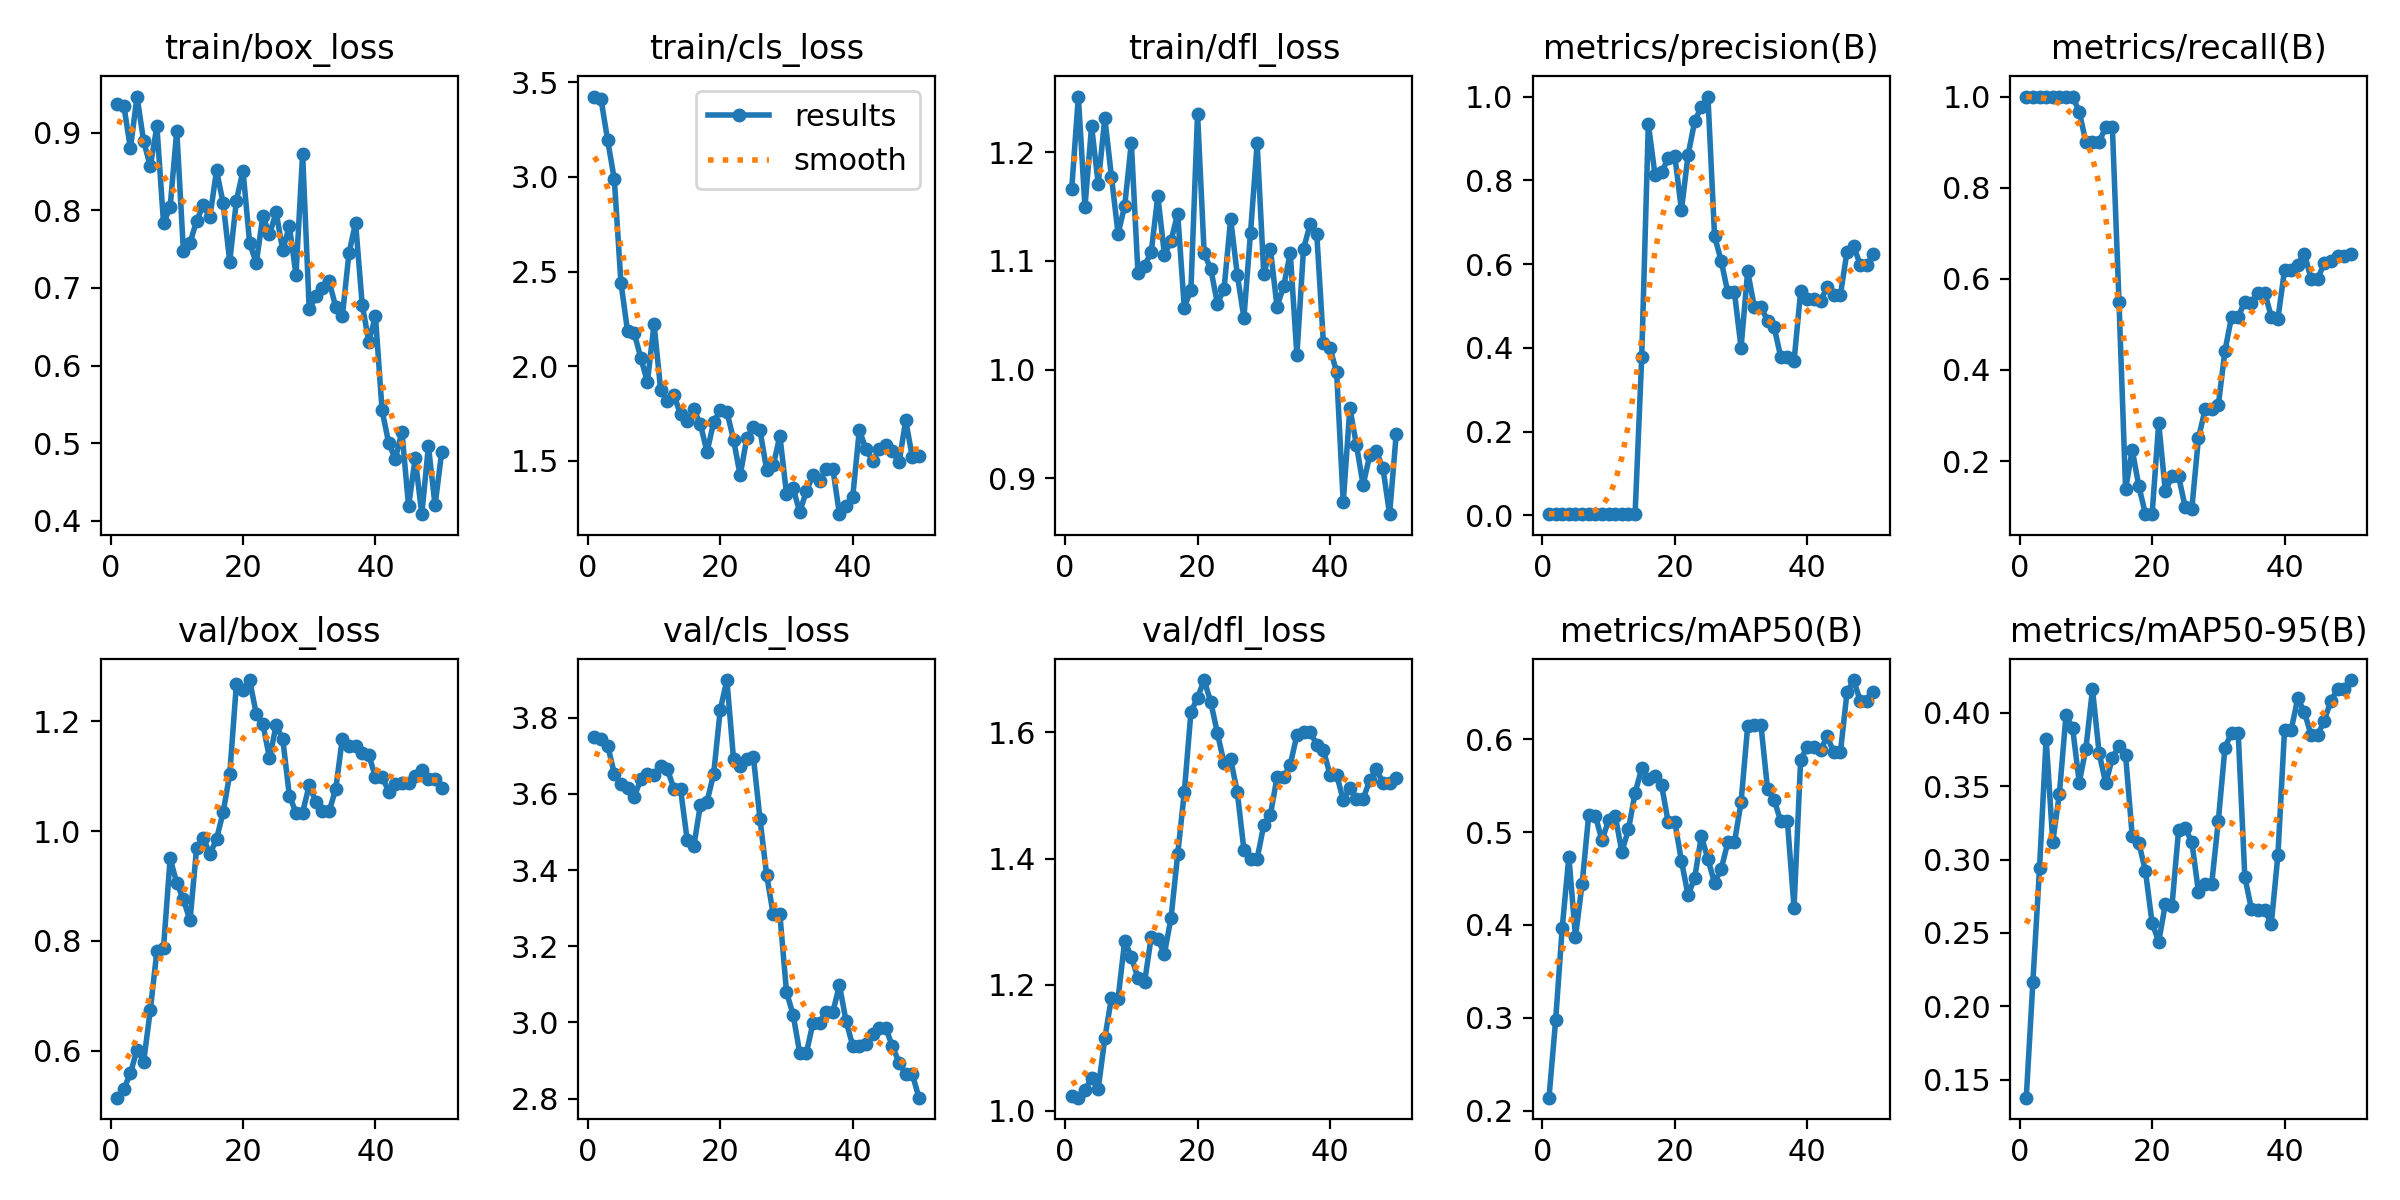

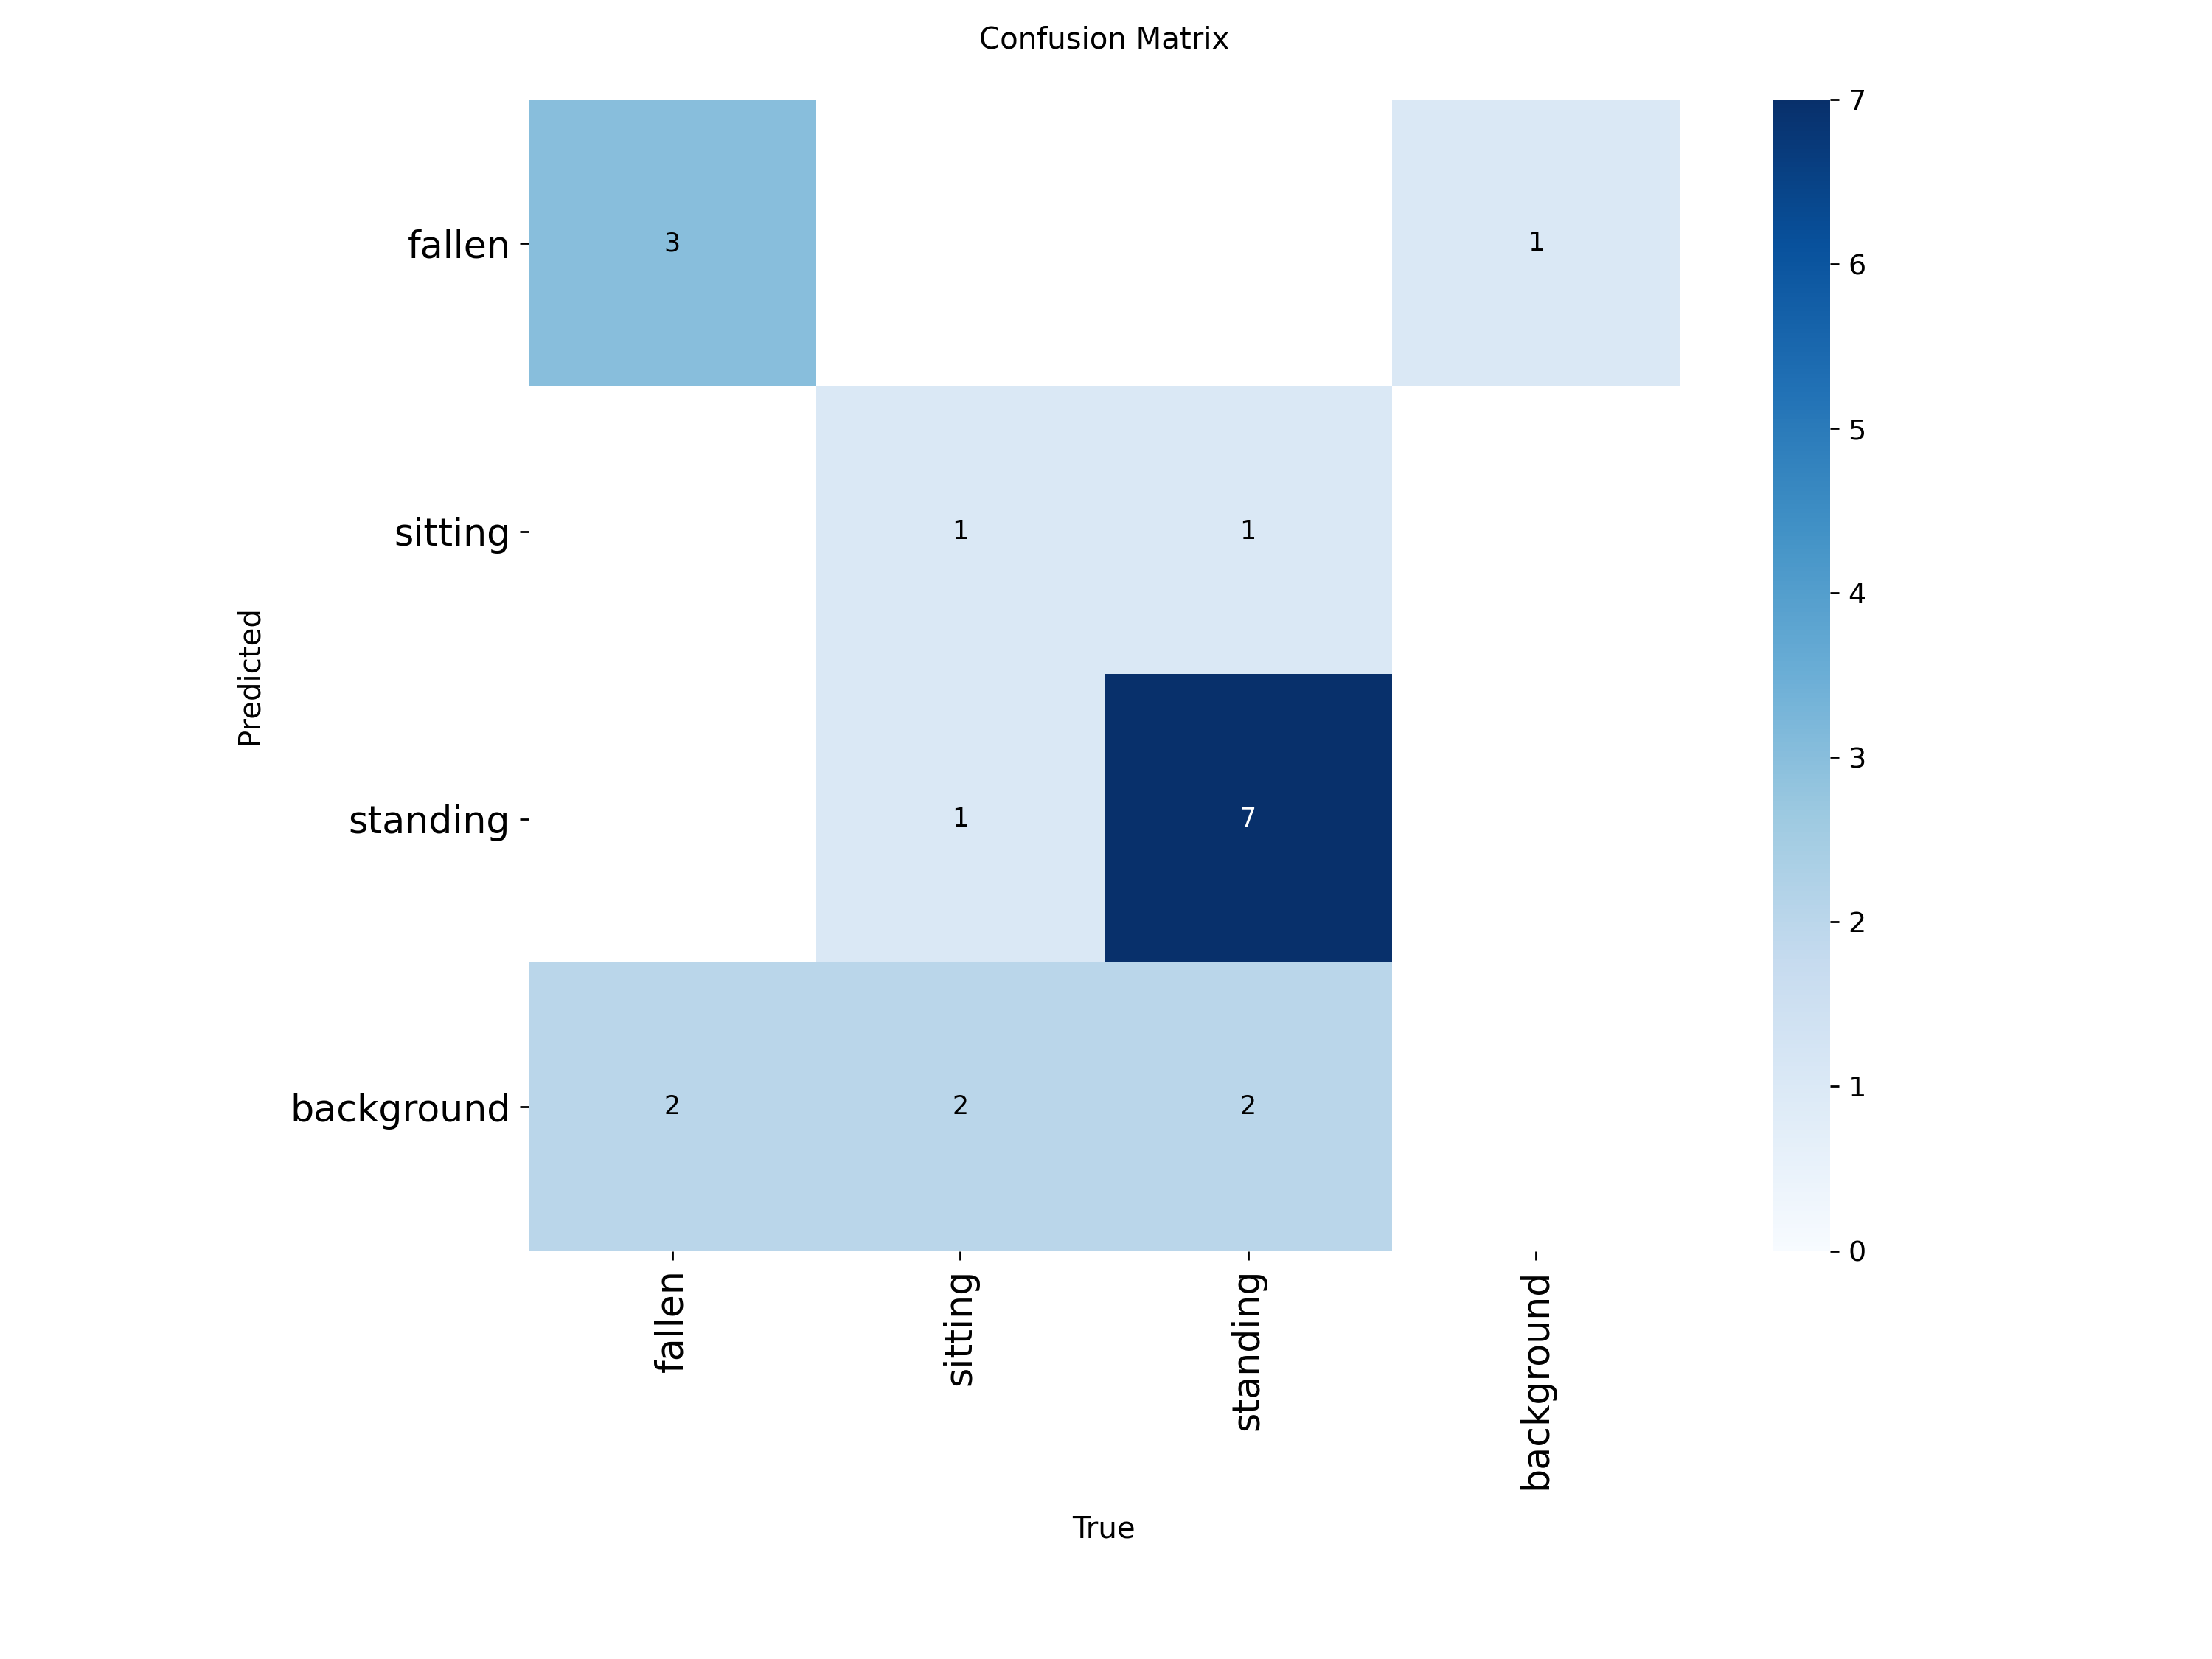

In [ ]:
!yolo detect val model=runs/detect/fall_yolov8n_baseline/weights/best.pt data=$yaml_path
!yolo detect val model=runs/detect/fall_yolov8n_tuned/weights/best.pt data=$yaml_path

## **Predict**

In [ ]:
TEST_IMAGES = f"{MERGED_PATH}/images/test"

!yolo detect predict model=runs/detect/fall_yolov8n_baseline/weights/best.pt source=$TEST_IMAGES save=True name="baseline_preds"
!yolo detect predict model=runs/detect/fall_yolov8n_tuned/weights/best.pt source=$TEST_IMAGES save=True name="tuned_preds"

## **Results**

In [ ]:
from IPython.display import Image, display

print("📈 Baseline Training Results")
display(Image(filename='runs/detect/fall_yolov8n_baseline/results.png'))

print("📈 Tuned Training Results")
display(Image(filename='runs/detect/fall_yolov8n_tuned/results.png'))

## **Precision, Recall, Curves**

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

baseline_csv = "runs/detect/fall_yolov8n_baseline/results.csv"
tuned_csv = "runs/detect/fall_yolov8n_tuned/results.csv"

baseline_df = pd.read_csv(baseline_csv)
tuned_df = pd.read_csv(tuned_csv)

plt.figure(figsize=(12, 8))

# Plot Precision
plt.subplot(3, 1, 1)
plt.plot(baseline_df["epoch"], baseline_df["metrics/precision(B)"], label="Baseline Precision", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/precision(B)"], label="Tuned Precision", color="orange")
plt.title("Precision Comparison")
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(3, 1, 2)
plt.plot(baseline_df["epoch"], baseline_df["metrics/recall(B)"], label="Baseline Recall", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/recall(B)"], label="Tuned Recall", color="orange")
plt.title("Recall Comparison")
plt.legend()
plt.grid(True)

# Plot mAP50
plt.subplot(3, 1, 3)
plt.plot(baseline_df["epoch"], baseline_df["metrics/mAP50(B)"], label="Baseline mAP@50", color="blue")
plt.plot(tuned_df["epoch"], tuned_df["metrics/mAP50(B)"], label="Tuned mAP@50", color="orange")
plt.title("mAP@50 Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()